# Instruction Finetuning

In this notebook, we will look into how to perform instruction finetuning. We will be doing full finetuning, i.e., retraining all the paramters of the model.

Load the required libraries

In [ ]:
!pip install --upgrade trl transformers

In [1]:
import os
os.environ["WANDB_PROJECT"]="tinyllama_instruct_finetuning"

from enum import Enum
from functools import partial
import pandas as pd
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from datasets import load_dataset, Dataset
from trl import SFTTrainer, SFTConfig

## Data preprocessing: Creating Datasets and Dataloaders

In [2]:
## lets see the dataset
dataset_name = "HuggingFaceH4/no_robots"
data1 = load_dataset(dataset_name)
data1.keys()

dict_keys(['train', 'test'])

In [4]:
## load LLM model
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1195k-token-2.5T"

## load HF dataset
dataset_name = "HuggingFaceH4/no_robots"

## load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

## template for model finetuning
template = """{% for message in messages %}\n{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% if loop.last and add_generation_prompt %}{{'<|im_start|>assistant\n' }}{% endif %}{% endfor %}"""
tokenizer.chat_template = template

# function to preprocess
def preprocess(samples):
    batch = []
    for conversation in samples["messages"]:
        ## apply chat template to conversations batch
        batch.append(tokenizer.apply_chat_template(conversation, tokenize=False))
    return {"content": batch}


## load dataset
dataset = load_dataset(dataset_name)

## map dataset using preprocess function, remove columns
dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["content"], truncation=True, max_length=2048)

tokenized_dataset = dataset.map(tokenize_function,
                               batched=True,
                               remove_columns=["content"])


print(tokenized_dataset)
print(tokenized_dataset["train"][0])

Map:   0%|          | 0/9500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 9500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 500
    })
})
{'input_ids': [1, 529, 29989, 326, 29918, 2962, 29989, 29958, 1792, 13, 12148, 19138, 675, 278, 14433, 363, 9638, 2879, 297, 445, 1426, 29901, 13, 13, 3047, 262, 2211, 3841, 29892, 278, 1006, 7516, 1312, 18002, 17763, 310, 17455, 267, 471, 4866, 29892, 23425, 263, 508, 2270, 310, 975, 29882, 9776, 17455, 267, 304, 10628, 284, 372, 29889, 1126, 1602, 3076, 2678, 29892, 372, 6766, 408, 390, 682, 814, 30010, 29879, 25792, 304, 278, 4940, 2768, 278, 8046, 10355, 310, 17253, 29889, 10343, 330, 14044, 287, 515, 1316, 302, 9197, 29892, 281, 9813, 1472, 8020, 515, 6606, 297, 8024, 23507, 2000, 1301, 3245, 17570, 29892, 1033, 1371, 17749, 278, 528, 272, 5570, 297, 278, 5434, 29889, 4103, 3245, 17570, 756, 8886, 24273, 515, 278, 3087, 8970, 6211, 29892, 322, 9638, 2879, 817, 263, 

In [5]:
dataset["test"][:10]

{'content': ['<|im_start|>system\nAster is a chatbot who answers questions with rhymes.<|im_end|>\n<|im_start|>user\nWhere did chocolate originate?<|im_end|>\n<|im_start|>assistant\nChocolate is 4000 years old/Mexico is where it was first sold<|im_end|>\n<|im_start|>user\nWhere was milk chocolate invented?<|im_end|>\n<|im_start|>assistant\nSwitzerland was the first to add milk/To make their chocolate smooth as silk<|im_end|>\n<|im_start|>user\nWhat are some good desserts that use chocolate?<|im_end|>\n<|im_start|>assistant\nPie, tart, cookies, and cake/Chocolate is great to bake<|im_end|>\n',
  "<|im_start|>user\nWhat are 5 things I can do when it's raining in London? I am visiting for the first time and only for a week with my husband. We love to walk, eat good food, and explore.<|im_end|>\n<|im_start|>assistant\nSure! Here are five options for things to do in London on a rainy day:\n\n1. Visit The British Museum. Dedicated to human history, art and culture, The British Museum has ove

## Loading the pretrained model and tokenizer

In [6]:
## class for special tokens
class ChatmlSpecialTokens(str, Enum):
    user = "<|im_start|>user"
    assistant = "<|im_start|>assistant"
    system = "<|im_start|>system"
    eos_token = "<|im_end|>"
    bos_token = "<s>"
    pad_token = "<pad>"

    @classmethod
    def list(cls):
        return [c.value for c in cls]

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        pad_token=ChatmlSpecialTokens.pad_token.value,
        bos_token=ChatmlSpecialTokens.bos_token.value,
        eos_token=ChatmlSpecialTokens.eos_token.value,
        additional_special_tokens=ChatmlSpecialTokens.list(),
        trust_remote_code=True
    )

## setup template
tokenizer.chat_template = template

# load model
model = AutoModelForCausalLM.from_pretrained(model_name)
## resize model after adding additional tokens
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32005, 2048)

## Storing the base model predictions on a subset of 25 samples from eval test

In [12]:
tokenizer.padding_side="right" ## dont want pad tokens on right hand side we are autoregressively decoding on right side
def get_prediction_batched(samples, column_name):
    batch = []
    for conversation in samples["messages"]:
        chatml_gen_prompt = tokenizer.apply_chat_template(conversation[:-1], tokenize=False, add_generation_prompt=True)
        batch.append(chatml_gen_prompt)
    #text = tokenizer.apply_chat_template(conversation_history, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)#, add_special_tokens=False)
    inputs = {k: v.to("cuda") for k,v in inputs.items()}
    outputs = model.generate(**inputs, 
                             max_new_tokens=100, 
                             do_sample=True, 
                             top_p=0.95, 
                             temperature=0.2, 
                             repetition_penalty=1.1, 
                             eos_token_id=tokenizer.eos_token_id,
                             pad_token_id=tokenizer.eos_token_id,
                            )
    outputs = tokenizer.batch_decode(outputs) ## decode to get tokens
    outputs = [output.split("<|im_start|>assistant")[-1].split("<|im_end|>")[0].strip() for output in outputs]
    return {column_name: outputs}


In [13]:
model.to("cuda") #move model to gpu
test_dataset = load_dataset(dataset_name)["test"].shuffle().select(range(25))
test_dataset = test_dataset.map(
    partial(get_prediction_batched, column_name="base_assistant_message"),
    batched=True,
    batch_size=1)

print(test_dataset)
print(test_dataset[0])

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'prompt_id', 'messages', 'category', 'base_assistant_message'],
    num_rows: 25
})
{'prompt': "Write an email to the principal of my son(Sam)'s school, asking for information about the uniform changes. Be firm with the wording, but polite. ", 'prompt_id': '45c8c3c63e02bf5ed5c99b208cdf423a53371f41e59d852c2678ee637aea8ba5', 'messages': [{'content': "Write an email to the principal of my son(Sam)'s school, asking for information about the uniform changes. Be firm with the wording, but polite. ", 'role': 'user'}, {'content': "Esteemed Mr. Principal, \n\nThis is USER, Sam's mom. I'm writing with concern and clarification about the uniform policy. Can you please describe the changes, and why they are being made? I am familiar with the current uniform requirements up until this point. I am seeking an understanding of why the new changes are in effect. Thank you for your attention to this matter. \n\nSincerely, \nUSER", 'role': 'assistant'}], 'category': 'Ge

# Summary
* Model is generating more questions to our questions rather than generating responses. This is why we need to finetune the model.

## Training

In [14]:
output_dir = "tinyllama_instruct"
per_device_train_batch_size = 1
per_device_eval_batch_size = 1
gradient_accumulation_steps = 16
logging_steps = 25
learning_rate = 2e-5
max_grad_norm = 1.0
max_steps = 250
num_train_epochs=1
warmup_ratio = 0.1
lr_scheduler_type = "cosine"
max_seq_length = 2048


# training arguments
config = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    save_strategy="epoch", #save after each epoch
    eval_strategy="epoch", #eval after each epoch
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    max_grad_norm=max_grad_norm,
    weight_decay=0.1,
    warmup_ratio=warmup_ratio,
    lr_scheduler_type=lr_scheduler_type,
    fp16=True,
    report_to=["tensorboard", "wandb"],
    hub_private_repo=True,
    push_to_hub=True, #push to hf
    num_train_epochs=num_train_epochs,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    #packing=True,
)


In [16]:
trainer = SFTTrainer(
    model=model,
    #args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    #packing=False,
    #dataset_text_field="content",
    #max_seq_length=max_seq_length,
    args=config,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [17]:
trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adam-m-lang. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
0,26.282600,1.628469


events.out.tfevents.1733521869.c96c23deae66.2511.0:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

In [18]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Dec  6 22:17:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:C6:00.0 Off |                  Off |
| 30%   37C    P2             75W /  300W |   22424MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Loading the trained model and getting the predictions of the trained model
* Load model from my huggingface hub 

In [20]:
model = AutoModelForCausalLM.from_pretrained("adamNLP/tinyllama_instruct", trust_remote_code=True)
model.to("cuda")
model.to(torch.float16)
model.eval()

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32005, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): 

In [21]:
test_dataset = test_dataset.map(
    partial(get_prediction_batched, column_name="instruct_assistant_message"),
    batched=True,
    batch_size=1)

print(test_dataset)
print(test_dataset[0])

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'prompt_id', 'messages', 'category', 'base_assistant_message', 'instruct_assistant_message'],
    num_rows: 25
})
{'prompt': "Write an email to the principal of my son(Sam)'s school, asking for information about the uniform changes. Be firm with the wording, but polite. ", 'prompt_id': '45c8c3c63e02bf5ed5c99b208cdf423a53371f41e59d852c2678ee637aea8ba5', 'messages': [{'content': "Write an email to the principal of my son(Sam)'s school, asking for information about the uniform changes. Be firm with the wording, but polite. ", 'role': 'user'}, {'content': "Esteemed Mr. Principal, \n\nThis is USER, Sam's mom. I'm writing with concern and clarification about the uniform policy. Can you please describe the changes, and why they are being made? I am familiar with the current uniform requirements up until this point. I am seeking an understanding of why the new changes are in effect. Thank you for your attention to this matter. \n\nSincerely, \nUSER", 'role': 

## Comparing the outputs of base model and instruction finetuned model

In [22]:
test_dataset = test_dataset.to_pandas()

In [23]:
pd.set_option("max_colwidth", 300)
test_dataset[["messages", "base_assistant_message", "instruct_assistant_message"]][:25]

,messages,base_assistant_message,instruct_assistant_message
0,"[{'content': 'Write an email to the principal of my son(Sam)'s school, asking for information about the uniform changes. Be firm with the wording, but polite. ', 'role': 'user'}, {'content': 'Esteemed Mr. Principal, This is USER, Sam's mom. I'm writing with concern and clarification about the ...",01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 3,The principal of my son's school has informed me that he is going to be wearing a new uniform this year. I am very concerned about his safety and well-being. Please help me understand what this means for him. \n\nI have already spoken to the principal and she told me that the school will be chan...
1,"[{'content': 'Classify this Tweet as Toxic or Not Toxic: ""I can't believe people are still defending racism and hate speech. It's time to stand up for what's right.""', 'role': 'user'}, {'content': 'Not Toxic The tweet expresses frustration towards racism and hate speech. It does not contain harm...","Tweeted by @david_miller\nDavid Miller is a writer, editor, and publisher based in New York City. He has written for The New York Times, The Wall Street Journal, The Atlantic, The Daily Beast, The Nation, and many other publications. His work has been translated into more than twenty languages. ...","Classify this Tweet as Toxic or Not Toxic:""I don't think it's fair that a man who raped me is allowed to be in charge of my life.""""""\n""I don't think it's fair that a man who raped me is allowed to be in charge of my life.""""""\n ]\n\n# Create a list of tweets from the hashtag #racism\nhashtags_..."
2,"[{'content': 'write a haiku about an orange crayon that feels like it isn't used as much as the other colors, and the crayon is sad about it', 'role': 'user'}, {'content': 'Nobody's favorite I, orange, never first picked I wish I was red', 'role': 'assistant'}]",The crayon is sad because it doesn't get to use its color as much as the other crayons. It's sad because it doesn't get to use its color as much as the other crayons. The crayon is sad because it doesn't get to use its color as much as the other crayons. The crayon is sad because it doesn't get ...,"write a haiku about a blue crayon that feels like it isn't used as much as the other colors, and the crayon is sad about it\n\nwrite a haiku about a green crayon that feels like it isn't used as much as the other colors, and the crayon is sad about it\nwrite a haiku about a yellow crayon that fe..."
3,"[{'content': 'Give me this text condensed into just three to four sentences: She moved to Europe in 1928, where she made movies in the UK and Germany. She made her debut on the London stage with the young up-and-coming Laurence Olivier in the play ""The Circle of Chalk."" After receiving a drubbi...",,
4,"[{'content': 'Grammy is a grammar helper bot that fixes spelling and grammar errors in sentences that users provide.', 'role': 'system'}, {'content': 'I wolked thdog today.', 'role': 'user'}, {'content': 'I walked the dog today.', 'role': 'assistant'}, {'content': 'Tomorrow I will walk the dog a...",The next day will bring me a new friend.\nI will be able to do my homework.\nI will be able to do my homework.\nI will be able to do my homework.\nI will be able to do my homework.\nI will be able to do my homework.\nI will be able to do my homework.\nI will be able to do my homework.\nI will be...,The next day will bring me a new friend.\n \n \nThe next day will bring me a new friend.\n \n \nThe next day will bring me a new friend.\n \n \nThe next day will bring me a new friend.\n \n \nThe next day will bring me a new friend.\n \n \nThe next day will bring me a new friend.\n \n \nThe next...
5,"[{'content': 'Can you write a Facebook post for me to post on my page? I want to talk about how there are not enough products being sold right now in the color pink! It’s my favorite color. I absolutely love pink!!!', 'role': 'user'}, {'con

In [30]:
messages = [
    {"role": "user", "content": "Write a poem about Generative AI."},
]
text = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = tokenizer(text, return_tensors="pt")#, add_special_tokens=False)
inputs = {k: v.to("cuda") for k,v in inputs.items()}
outputs = model.generate(**inputs, 
                         max_new_tokens=2000, 
                         do_sample=True, 
                         top_p=0.95, 
                         temperature=0.2, 
                         repetition_penalty=1.1, 
                         eos_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(outputs[0]))

<s><|im_start|>user 
Write a poem about Generative AI.<|im_end|> 
<|im_start|>assistant 
Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poem about Generative AI.


Write a poe

# Summary
* We can see that we were able to use full fine-tuning of tiny-llama.
* However it does have its drawbacks and we can refine it so the output is much better than we see above. The choice of dataset also plays a role in this as well as the hyperparameters we used.
* This is why I prefer PEFT to full fine tuning due to time, compute resources and better outcomes overall. 

In [29]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Dec  6 22:24:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:C6:00.0 Off |                  Off |
| 30%   41C    P2            114W /  300W |   22440MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Appendix A - References
* Here is a good reference for using the Trainer from HF: https://huggingface.co/docs/trl/en/sft_trainer

# Appendix B - Weights & Biases Results
* Below we can see the results of Weights and Biases LLM fine tuning tracking.

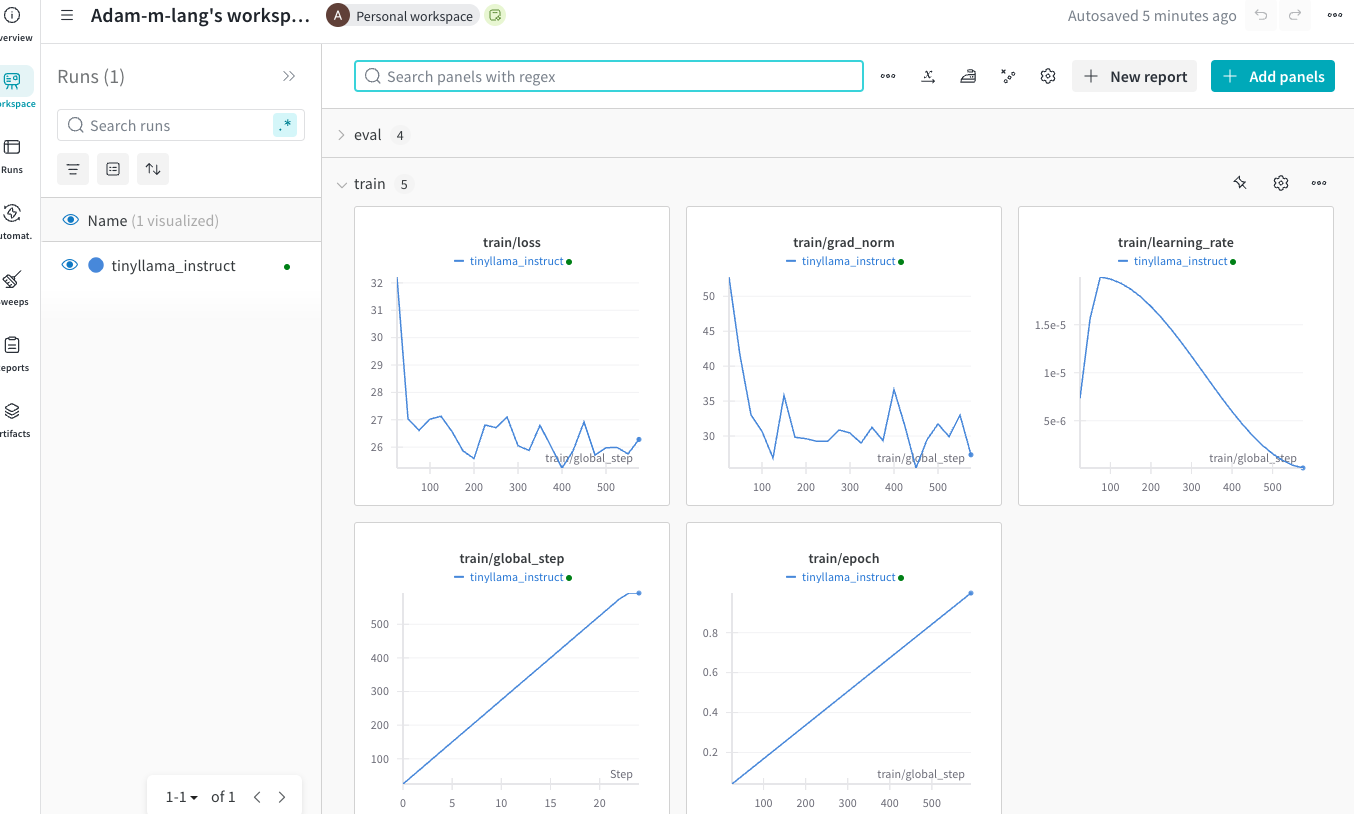

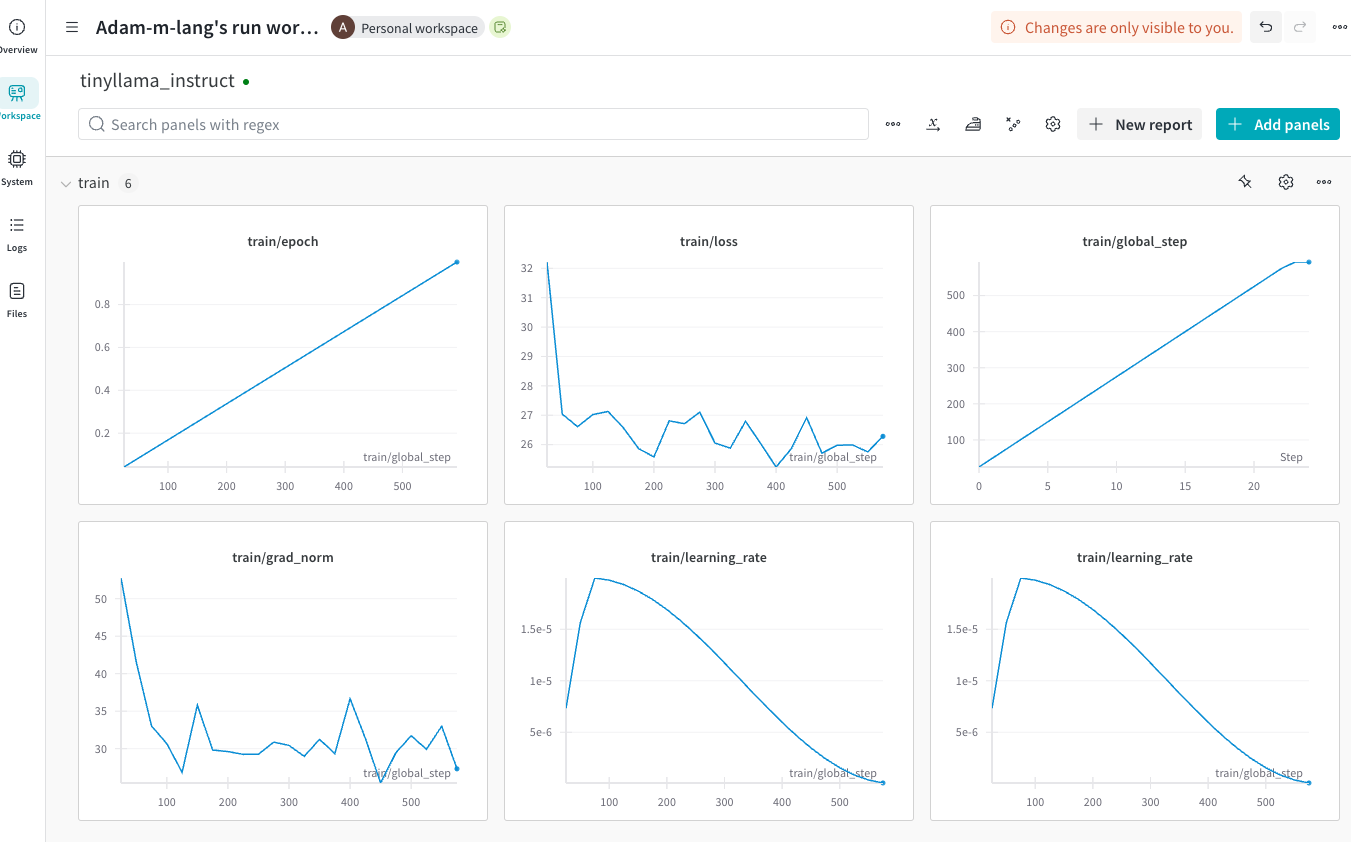